In [20]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import GENConv, GATv2Conv, SSGConv
import numpy as np
from torch_geometric.data import Data
from torch.utils.data import DataLoader
import torch_geometric.utils

from tqdm import tqdm

from sklearn.model_selection import KFold
import pandas as pd
from MatrixVectorizer import MatrixVectorizer


In [21]:
# set global variables
N_SUBJECTS = 167

N_LR_NODES = 160

N_HR_NODES = 268

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

N_LR_NODES_F = int(N_LR_NODES * (N_LR_NODES-1) / 2)
N_HR_NODES_F = int(N_HR_NODES * (N_HR_NODES-1) / 2)

In [22]:
from data_preparation import load_data_tensor

lr_train, lr_test, hr_train = load_data_tensor("dgl-icl")

lr_X_dim1 = torch.load('model_autoencoder/final_embeddings/encode_lr.pt')
lr_X_dim3 = torch.load('model_autoencoder/final_embeddings/encode_lr_3.pt')
hr_X_dim1 = torch.load('model_autoencoder/final_embeddings/encode_hr.pt')
hr_X_dim3 = torch.load('model_autoencoder/final_embeddings/encode_hr_3.pt')
lr_X_dim1_test = torch.load('model_autoencoder/final_embeddings/encode_lr_test.pt')
hr_X_dim3_test = torch.load('model_autoencoder/final_embeddings/encode_lr_test_3.pt')

# Model Layers

In [23]:
def generate_steps(num_steps, low=N_LR_NODES, high=N_HR_NODES):
    step_size = (high - low) / (num_steps - 1)
    steps_list = [round(low + step_size * i) for i in range(num_steps)]
    return steps_list

In [24]:
class StackedGCN(nn.Module):
    def __init__(self, n_nodes, channel_ls, dropout):
        super().__init__()
        self.n_nodes = n_nodes
        self.gcn_layers, self.batch_norm_layers = self._init_layers(channel_ls)

        # self.gcn_layers, _ = self._init_layers(channel_ls)
        self.dropout = dropout
        
    
    def forward(self, X, A):
        for i in range(len(self.gcn_layers)):
            gcn = self.gcn_layers[i]
            batch_norm = self.batch_norm_layers[i]
            graph_batch = self._create_batch(X, A)
            
            X = F.sigmoid(gcn(graph_batch.x, graph_batch.edge_index, graph_batch.edge_attr).reshape(*X.shape[:2], -1))
            torch.cuda.empty_cache()
            X = F.dropout(batch_norm(X), self.dropout, training=self.training)
            # X = F.dropout(X, self.dropout, training=self.training)
            torch.cuda.empty_cache()

        return X

    def _init_layers(self, channel_ls):
        layers_ls = []
        batch_norm_ls = []
        for i in range(len(channel_ls) - 1):
            # layer = GENConv(channel_ls[i], channel_ls[i+1], aggr='powermean', learn_p=True, edge_dim=1)
            layer = GATv2Conv(channel_ls[i], channel_ls[i], heads=2, edge_dim=1)
            layers_ls.append(layer)
            batch_norm_ls.append(torch_geometric.nn.norm.BatchNorm(self.n_nodes))
        return nn.ModuleList(layers_ls), nn.ModuleList(batch_norm_ls)

    def _create_batch(self, X, A):
        data_list = []
        for x, adj in zip(X, A):
            edge_index = adj.nonzero().t()
            edge_weights = adj[edge_index[0], edge_index[1]]
            edge_index, edge_weights = torch_geometric.utils.add_self_loops(edge_index, edge_weights) # add self connections
            data = Data(x=x, edge_index=edge_index, edge_attr=edge_weights.view(-1, 1))
            data_list.append(data)
        return torch_geometric.data.Batch().from_data_list(data_list)

In [67]:
class AdjacencyStep(nn.Module):
    def __init__(self, old_dim, new_dim, channels_ls, dt=1., alpha=0.2, gamma=0.2, dropout=0.5):
        super().__init__()
        self.dt = dt
        self.alpha = alpha
        self.gamma = gamma
        self.gnn = StackedGCN(old_dim, channels_ls, dropout).to(DEVICE)
        self.dropout = dropout
        self.dim_changer1 = nn.Parameter(torch.randn((new_dim, 1), device=DEVICE))
        self.dim_changer2 = nn.Parameter(torch.randn((1, old_dim), device=DEVICE))
        # self.dim_changer = nn.Parameter(torch.randn((new_dim, old_dim), device=DEVICE))

        # self.A_dim_changer = nn.Parameter(torch.randn((new_dim, old_dim), device=DEVICE))
        self.A_dim_changer1 = nn.Parameter(torch.randn((new_dim, 1), device=DEVICE))   
        self.A_dim_changer2 = nn.Parameter(torch.randn((1, old_dim), device=DEVICE))
        self.A_dim_bias = nn.Parameter(torch.randn((new_dim, 1), device=DEVICE))

        # self.Z_dim_changer = nn.Parameter(torch.randn((channels_ls[-1], new_dim), device=DEVICE))
        self.Z_dim_changer1 = nn.Parameter(torch.randn((channels_ls[-1], 1), device=DEVICE))   
        self.Z_dim_changer2 = nn.Parameter(torch.randn((1, new_dim), device=DEVICE))
        self.Z_dim_bias = nn.Parameter(torch.randn((new_dim, 1), device=DEVICE))

        self.Z_dim_lower = nn.Conv1d(channels_ls[-1], channels_ls[0], kernel_size=1)


        self.forget_gate = nn.Parameter(torch.randn(new_dim, device=DEVICE))
        self.input_gate = nn.Parameter(torch.randn(new_dim, device=DEVICE))

        self.batchnorm_A = torch_geometric.nn.norm.BatchNorm(new_dim)
        self.layernorm_forget_A = torch_geometric.nn.norm.LayerNorm((new_dim, new_dim))
        self.layernorm_input_Z = torch_geometric.nn.norm.LayerNorm((new_dim, new_dim))
        self.batchnorm_X = torch_geometric.nn.norm.BatchNorm(new_dim)
        self.batchnorm_Y = torch_geometric.nn.norm.BatchNorm(new_dim)



    def forward(self, X, Y, A):
        # solve ODEs using simple IMEX scheme
        dim_changer = self.dim_changer1 @ self.dim_changer2 
        A_dim_changer = self.A_dim_changer1 @ self.A_dim_changer2
        Z_dim_changer = self.Z_dim_changer1 @ self.Z_dim_changer2
        # dim_changer = self.dim_changer
        # A_dim_changer = self.A_dim_changer
        # Z_dim_changer = self.Z_dim_changer

        # forget gate from previous adjacency
        f = F.sigmoid(self.forget_gate)
        i = F.sigmoid(self.input_gate)
        forget_A = F.elu(A_dim_changer @ A @ A_dim_changer.T + self.A_dim_bias)
        forget_A = f[:, None] * self.layernorm_forget_A(forget_A)
        # forget_A = f[:, None] * forget_A
        torch.cuda.empty_cache()

    
        # update node features with gcn
        Z = self.gnn(X, A)
        torch.cuda.empty_cache()
        input_Z = F.elu(dim_changer @ Z @ Z_dim_changer + self.Z_dim_bias)
        input_Z = i[:, None] * self.layernorm_input_Z(input_Z)
        # input_Z = i[:, None] * input_Z
        torch.cuda.empty_cache()



        # get new adjacency matrix
        new_A = forget_A + input_Z
        new_A = self.batchnorm_A(new_A)
        new_A = (new_A + torch.transpose(new_A, -1, -2)) / 2
        # new_A = F.tanh(F.relu(new_A))
        new_A = F.sigmoid(new_A)


        torch.cuda.empty_cache()


        # update feature embeiddings
        Z = torch.transpose(self.Z_dim_lower(torch.transpose(Z, -1, -2)), -1, -2)
        Y_temp = Y
        Y = dim_changer @ (Y + self.dt * (Z - self.alpha * Y - self.gamma * X))
        X = dim_changer @ (X + self.dt * Y_temp) 

        X = self.batchnorm_X(X)
        Y = self.batchnorm_Y(Y)   
        torch.cuda.empty_cache()


        Y = F.dropout(Y, self.dropout, training=self.training)
        X = F.dropout(X, self.dropout, training=self.training)

        return X, Y, new_A

    

In [26]:
class AdjacencyDimChanger(nn.Module):

    def __init__(self, dim_steps, channels_ls):
        super().__init__()
        
        self.layers = nn.ModuleList([AdjacencyStep(dim_steps[i], dim_steps[i+1], channels_ls) for i in range(len(dim_steps)-1)])
        # self.batchnorms = nn.ModuleList([nn.BatchNorm1d(dim_steps[i+1]) for i in range(len(dim_steps)-1)])
        
    def forward(self, X, Y, A):
        adj_ls = [A]
        x, y, adj = X, Y, A
        
        for layer in self.layers:
            x, y, adj = layer(x, y, adj)
            adj_ls.append(adj)
            
        return adj_ls
        

In [27]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False

def unfreeze_model(model):
    for param in model.parameters():
        param.requires_grad = True

In [28]:
import numpy as np
import networkx as nx

def eigen_centrality(data):
    # ROI is the number of brain regions (i.e.,35 in our case)
    ROI = 160

    topology_eigen = []

    G = nx.from_numpy_array(np.absolute(data))
    U = G.to_undirected()

    # A = to_2d(data)
    np.fill_diagonal(data, 0)

    # create a graph frL2
    # # compute egeinvector centrality and transform the output to vector
    ec = nx.eigenvector_centrality_numpy(U)
    
    eigenvector_centrality = np.array([ec[g] for g in U])



    topology_eigen.append(eigenvector_centrality)  # 2

    return topology_eigen

def pearson_coor(input, target, epsilon=1e-7):
    vx = input - torch.mean(input, dim=(1, 2))[:, None, None]
    vy = target - torch.mean(target, dim=(1, 2))[:, None, None]
    cost = torch.sum(vx * vy) / (torch.sqrt(torch.sum(vx ** 2)+epsilon) * torch.sqrt(torch.sum(vy ** 2)+epsilon)+epsilon)
    return cost

def GT_loss(target, predicted):

    # l1_loss
    l1_loss = torch.nn.L1Loss()
    # loss_pix2pix = l1_loss(target, predicted)

    # topological_loss
    target_n = target.detach().cpu().clone().numpy()
    predicted_n = predicted.detach().cpu().clone().numpy()
    torch.cuda.empty_cache()

    topo_loss = []
    

    for i in range(len(target_n)):

        cur_target = target_n[i]
        cur_predicted = predicted_n[i]

        target_t = eigen_centrality(cur_target)
        real_topology = torch.tensor(target_t[0])
        predicted_t = eigen_centrality(cur_predicted)
        fake_topology = torch.tensor(predicted_t[0])
        topo_loss.append(l1_loss(real_topology, fake_topology))

    topo_loss = torch.sum(torch.stack(topo_loss))

    pc_loss = pearson_coor(target, predicted).to(DEVICE)
    torch.cuda.empty_cache()

    # G_loss = loss_pix2pix + (1 - pc_loss) + topo_loss
    G_loss = (1 - pc_loss) + topo_loss


    return G_loss

In [29]:
def loss_calc(adj_ls, opp_adj_ls, alpha=0.75, weights=None):
    total_loss = torch.Tensor([0]).to(DEVICE)
    mse_loss_fn = nn.MSELoss()

    # calculate the loss for the upper traingle of the matrix because thats what we care about
    final_dim = adj_ls[-1].shape[-1]
    upper_tri_idx = torch.triu_indices(final_dim, final_dim, offset=1)
    final_upper_tri_adj = adj_ls[-1][:,upper_tri_idx.unbind()[0], upper_tri_idx.unbind()[1]]
    final_upper_tri_other_adj = opp_adj_ls[0][:,upper_tri_idx.unbind()[0], upper_tri_idx.unbind()[1]]
    final_mse_loss = mse_loss_fn(final_upper_tri_adj, final_upper_tri_other_adj)

    if weights is None:
        n = len(adj_ls[1:-1])
        weights = torch.Tensor([2*(i+1)/(n*(n+1)) for i in range(n)])
    
    # calculate the loss for the remaining intermediate adjacent matrices
    intermediate_mse_loss = torch.Tensor([0]).to(DEVICE)
    for i, (adj, opp_adj) in enumerate(zip(adj_ls[:-1], opp_adj_ls[1:][::-1])):
        intermediate_mse_loss = intermediate_mse_loss + weights[i] * mse_loss_fn(adj, opp_adj)

    total_loss = total_loss + alpha * final_mse_loss + (1-alpha) * intermediate_mse_loss
    # total_loss = total_loss + alpha * final_mse_loss * (1 + intermediate_mse_loss) * (gamma ** 2)
    # total_loss = total_loss + (1-alpha) * intermediate_mse_loss * (beta ** 2)
        

    # gt_loss = torch.Tensor([0]).to(DEVICE)
    # for i, (adj, opp_adj) in enumerate(zip(adj_ls, opp_adj_ls[::-1])):

    #     ### NOTE TEMPORARY MEASURE BECAUSE THEY TAKE IN (BATCHSIZE, xx, xx) shape ####
    #     temp_adj = adj.reshape(1, *adj.shape)
    #     temp_opp_adj = opp_adj.reshape(1, *opp_adj.shape)
    #     ##########################################################
    #     gt_loss = gt_loss + GT_loss(temp_adj, temp_opp_adj)

    # gt_loss = gt_loss / n
        
    return total_loss

def up_loss_fn(up_adj_ls, down_adj_ls, alpha, epoch_weight):
    total_loss = torch.Tensor([0]).to(DEVICE)
    mse_loss_fn = nn.MSELoss()

    # calculate the loss for the upper traingle of the matrix because thats what we care about
    final_dim = up_adj_ls[-1].shape[-1]
    upper_tri_idx = torch.triu_indices(final_dim, final_dim, offset=1)
    final_upper_tri_adj = up_adj_ls[-1][:,upper_tri_idx.unbind()[0], upper_tri_idx.unbind()[1]]
    final_upper_tri_other_adj = down_adj_ls[0][:,upper_tri_idx.unbind()[0], upper_tri_idx.unbind()[1]]
    final_mse_loss = mse_loss_fn(final_upper_tri_adj, final_upper_tri_other_adj)

    n = len(up_adj_ls[:-1])
    weights = torch.Tensor([2*(i+1)/(n*(n+1)) for i in range(n)])
    
    # calculate the loss for the remaining intermediate adjacent matrices
    intermediate_mse_loss = torch.Tensor([0]).to(DEVICE)
    for i, (up_adj, down_adj) in enumerate(zip(up_adj_ls[:-1], down_adj_ls[1:][::-1])):
        intermediate_mse_loss = intermediate_mse_loss + weights[i] * mse_loss_fn(up_adj, down_adj)


    total_loss = total_loss + alpha * final_mse_loss + (1-alpha) * intermediate_mse_loss * epoch_weight
    return total_loss

def down_loss_fn(down_adj_ls, up_adj_ls):
    total_loss = torch.Tensor([0]).to(DEVICE)
    mse_loss_fn = nn.MSELoss()

    n = len(down_adj_ls[:])
    weights = torch.Tensor([1/n for i in range(n)])
    
    # calculate the loss for the remaining intermediate adjacent matrices
    intermediate_mse_loss = torch.Tensor([0]).to(DEVICE)
    for i, (down_adj, up_adj) in enumerate(zip(down_adj_ls[:], up_adj_ls[::-1])):
        total_loss = total_loss + weights[i] * mse_loss_fn(down_adj, up_adj)

    return total_loss

def end_adj_loss_calc(adj, opp_adj):
    mae_loss_fn = torch.nn.L1Loss()
    n = len(adj)
    upper_tri_idx = torch.triu_indices(n, n, offset=1)
    upper_tri_adj = adj.detach()[upper_tri_idx.unbind()]
    upper_tri_opp_adj = opp_adj.detach()[upper_tri_idx.unbind()]
    mae_loss = mae_loss_fn(upper_tri_adj, upper_tri_opp_adj)
    # temp_adj = adj.reshape(1, *adj.shape)
    # temp_opp_adj = opp_adj.reshape(1, *opp_adj.shape)
    # gt_loss = GT_loss(temp_adj, temp_opp_adj)
    return mae_loss.detach().item()

# Training

In [35]:
trainloader = DataLoader(list(zip(lr_X_dim1, lr_X_dim3, lr_train, hr_X_dim1, hr_X_dim3, hr_train)), shuffle=True, batch_size=8)
testloader = DataLoader(list(zip(lr_X_dim1_test, lr_X_dim3, lr_test)), shuffle=True, batch_size=32)

dim_steps = generate_steps(num_steps=8)
channels_ls = [32, 64, 128]

up_changer = AdjacencyDimChanger(dim_steps, channels_ls).to(DEVICE)
down_changer = AdjacencyDimChanger(dim_steps[::-1], channels_ls).to(DEVICE)

up_optimizer = torch.optim.AdamW(up_changer.parameters(), lr=0.001, betas=(0.5, 0.999))
down_optimizer = torch.optim.AdamW(down_changer.parameters(), lr=0.001, betas=(0.5, 0.999))

sum(p.numel() for model in [up_changer, down_changer] for p in model.parameters())


3038396

In [33]:
def train(epochs, up_changer, down_changer, trainloader, up_optimizer, down_optimizer, completed_epochs=0, loss_log=None):

    if loss_log is None:
        loss_log = {'up': [], 'down': [], 'up_end_mae':[], 'down_end_mae':[]}

    up_changer.train()
    down_changer.train()   

    beta = 1
    up_gamma = 1
    down_gamma = 1
    epoch_weight = 1
    for epoch in range(epochs):

        up_losses = []
        up_final_mae_ls = []
        down_final_mae_ls = []
        down_losses = []
            
        if (epoch + 1) % 10 == 0:
            epoch_weight = 1 / ((epoch + completed_epochs + 1) ** 0.2)


        for X_lr, Y_lr, adj_lr, X_hr, Y_hr, adj_hr in tqdm(trainloader):

            freeze_model(up_changer)
            unfreeze_model(down_changer)
        
            down_optimizer.zero_grad()
            up_optimizer.zero_grad()

            down_batch_loss = []
            
            up_adj_ls = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), adj_lr.to(DEVICE))
            torch.cuda.empty_cache()
            down_adj_ls = down_changer(X_hr.to(DEVICE), Y_hr.to(DEVICE), adj_hr.to(DEVICE))
            torch.cuda.empty_cache()

            down_batch_loss.append(down_loss_fn(down_adj_ls[1:], up_adj_ls[:-1]))
        
            # for printing loss only
            down_final_mae_ls.append(end_adj_loss_calc(down_adj_ls[-1].detach(), up_adj_ls[0].detach()))
            torch.cuda.empty_cache()
            
            # del down_end_adj_gt_loss
            down_loss = torch.mean(torch.stack(down_batch_loss))
            down_loss.backward()
            down_optimizer.step()

            down_losses.append(down_loss.detach().item())
            del down_loss
            del down_batch_loss
            torch.cuda.empty_cache()

            unfreeze_model(up_changer)
            freeze_model(down_changer)
        
            down_optimizer.zero_grad()
            up_optimizer.zero_grad()

            up_batch_loss = []

            up_adj_ls = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), adj_lr.to(DEVICE))
            torch.cuda.empty_cache()
            down_adj_ls = down_changer(X_hr.to(DEVICE), Y_hr.to(DEVICE), adj_hr.to(DEVICE))
            torch.cuda.empty_cache()
        
            up_batch_loss.append(up_loss_fn(up_adj_ls[1:], down_adj_ls[:-1], alpha=0.75, epoch_weight=epoch_weight))
            
            # for printing loss only
            up_final_mae_ls.append(end_adj_loss_calc(up_adj_ls[-1].detach(), down_adj_ls[0].detach()))
            torch.cuda.empty_cache()

            
            up_loss = torch.mean(torch.stack(up_batch_loss))
            up_loss.backward()
            up_optimizer.step()

            up_losses.append(up_loss.detach().item())
            del up_loss
            del up_batch_loss
            torch.cuda.empty_cache()

        
        epoch_up_loss = np.mean(up_losses)
        epoch_down_loss = np.mean(down_losses)
        epoch_up_final_mae = np.mean(up_final_mae_ls)
        epoch_down_final_mae = np.mean(down_final_mae_ls)
        
        loss_log['up'].append(epoch_up_loss)
        loss_log['down'].append(epoch_down_loss)
        loss_log['up_end_mae'].append(epoch_up_final_mae)
        loss_log['down_end_mae'].append(epoch_down_final_mae)

        print(f'epoch {epoch}: down loss = {epoch_down_loss}, up loss = {epoch_up_loss}, down adj mae = {epoch_down_final_mae}, up adj mae = {epoch_up_final_mae}')


    return up_changer, down_changer, loss_log


In [15]:
up_changer, down_changer, loss_log = train(300, up_changer, down_changer, trainloader, up_optimizer, down_optimizer)

100%|██████████| 21/21 [00:41<00:00,  1.95s/it]


epoch 0: down loss = 0.6296953076408023, up loss = 0.5100735908462888, down adj mae = 0.5739789959930238, up adj mae = 0.6064883584067935


 24%|██▍       | 5/21 [00:09<00:30,  1.88s/it]

In [17]:
min(loss_log['up_end_mae'])

0.13146179914474487

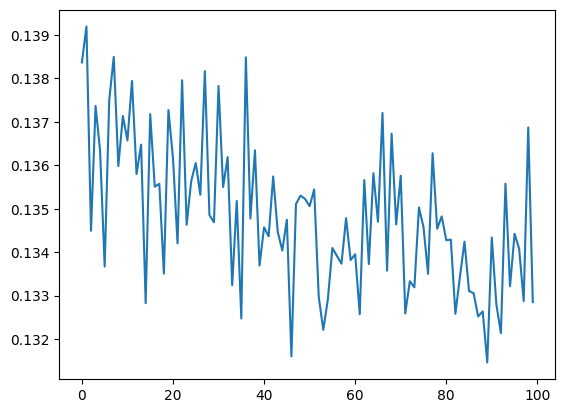

In [20]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(loss_log['up_end_mae'][-100:])), loss_log['up_end_mae'][-100:])
plt.show()

In [28]:
torch.save(up_changer.state_dict(), 'submission_files/tim_deep3/up_changer.pth')

In [29]:
# to generate test predictions
testloader = DataLoader(list(zip(lr_X_dim1_test, lr_X_dim3, lr_test)), shuffle=True, batch_size=32)

up_changer.eval()
test_predictions = []
for X_lr, Y_lr, adj_lr in tqdm(testloader):
    pred = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), adj_lr.to(DEVICE))[-1].detach()
    test_predictions.append(pred)
test_predictions = torch.cat(test_predictions)

100%|██████████| 4/4 [00:00<00:00,  4.99it/s]


In [30]:
torch.save(test_predictions, 'submission_files/tim_deep3/tim_deep3_pred.pt')

In [5]:
test_predictions = torch.load('submission_files/tim_deep3/tim_deep3_pred.pt')

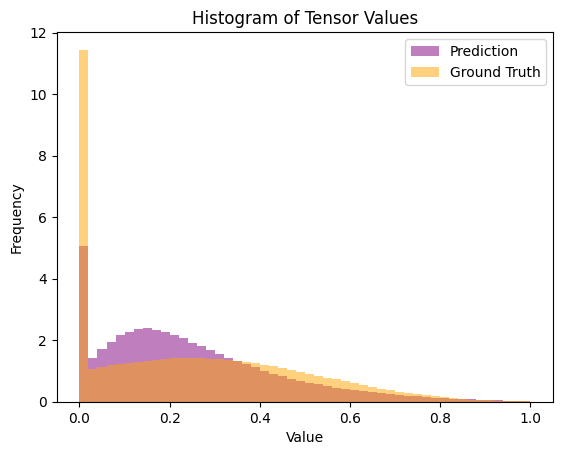

In [6]:
from data_preparation import generate_histogram
generate_histogram(test_predictions.cpu(), hr_train)

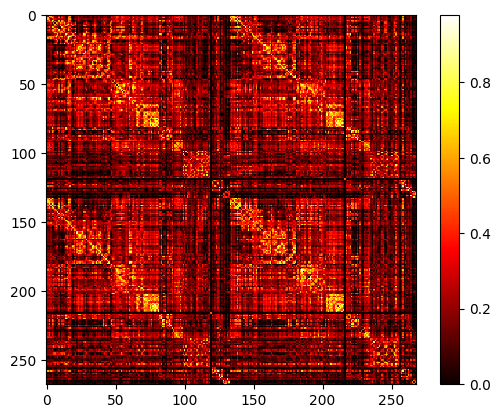

In [33]:
from data_preparation import generate_heatmap
generate_heatmap(test_predictions[0].cpu())

In [34]:
from data_preparation import generate_submission_file

df = generate_submission_file(test_predictions.cpu(), 'submission_files/tim_deep3/tim_deep3.csv')

# Cross Validation

In [75]:
from evaluation_fn import evaluate_predictions
from data_preparation import generate_histogram, generate_heatmap

def validation(up_changer, testloader, val_adj_hr, histogram=False, heatmap=False):
    print('begin validation')
    up_changer.eval()

    val_predictions = []
    for X_lr, Y_lr, adj_lr in tqdm(testloader):
        pred = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), adj_lr.to(DEVICE))[-1].detach()
        val_predictions.append(pred)
    val_predictions = torch.cat(val_predictions)

    if histogram:
        print(f'Histogram for Current Fold')
        generate_histogram(val_predictions.cpu(), val_adj_hr.cpu())
    if heatmap:
        print(f'First Difference Heatmap for Current Fold')
        generate_heatmap((val_adj_hr[0].cpu() - val_predictions[0].cpu()))

    return evaluate_predictions(val_predictions, val_adj_hr)

In [70]:
def cross_validate(epochs, batch_size, n_fold, X_lr, Y_lr, adj_lr, X_hr, Y_hr, adj_hr, num_steps, channels_ls = [32, 64, 128], histogram=False, heatmap=False):
    kf = KFold(n_fold, shuffle=True, random_state=99)
    runs_results = []
    for train_idx, val_idx in kf.split(X_lr):
        train_X_lr, val_X_lr = X_lr[train_idx], X_lr[val_idx]
        train_Y_lr, val_Y_lr = Y_lr[train_idx], Y_lr[val_idx]
        train_adj_lr, val_adj_lr = adj_lr[train_idx], adj_lr[val_idx]
        train_X_hr = X_hr[train_idx]
        train_Y_hr = Y_hr[train_idx]
        train_adj_hr, val_adj_hr = adj_hr[train_idx], adj_hr[val_idx]

        trainloader = DataLoader(list(zip(train_X_lr, train_Y_lr, train_adj_lr, train_X_hr, train_Y_hr, train_adj_hr)), shuffle=True, batch_size=batch_size)

        dim_steps = generate_steps(num_steps=10)

        up_changer = AdjacencyDimChanger(dim_steps, channels_ls).to(DEVICE)
        down_changer = AdjacencyDimChanger(dim_steps[::-1], channels_ls).to(DEVICE)

        up_optimizer = torch.optim.AdamW(up_changer.parameters(), lr=0.001, betas=(0.5, 0.999))
        down_optimizer = torch.optim.AdamW(down_changer.parameters(), lr=0.001, betas=(0.5, 0.999))    
        
        up_changer, down_changer, _ = train(epochs, up_changer, down_changer, trainloader, up_optimizer, down_optimizer)

        testloader = DataLoader(list(zip(val_X_lr, val_Y_lr, val_adj_lr)), shuffle=True, batch_size=batch_size)
        val_metrics = validation(up_changer, testloader, val_adj_hr, histogram, heatmap)
        runs_results.append(val_metrics)


    return runs_results

100%|██████████| 14/14 [00:32<00:00,  2.31s/it]


epoch 0: down loss = 0.06541824394038745, up loss = 0.11067276767321996, down adj mae = 0.32734730413981844, up adj mae = 0.29162134655884336
begin validation


100%|██████████| 7/7 [00:03<00:00,  2.23it/s]


Histogram for Current Fold


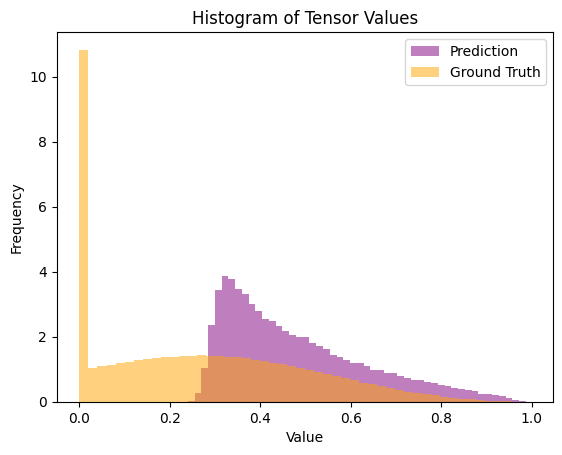

First Difference Heatmap for Current Fold


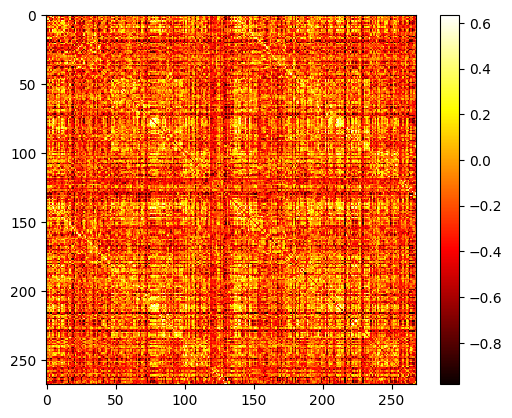

Evaluating Predictions (Can be Slow): 100%|██████████| 56/56 [15:30<00:00, 16.61s/it]


MAE:  0.2831261
PCC:  0.016045646877525372
Jensen-Shannon Distance:  0.3595045519634787
Average MAE betweenness centrality: 0.01553026581030569
Average MAE eigenvector centrality: 0.01771562145462533
Average MAE PageRank centrality: 0.0007814239284529283


100%|██████████| 14/14 [00:32<00:00,  2.33s/it]


epoch 0: down loss = 0.06336802483669349, up loss = 0.10759251724396433, down adj mae = 0.3260772313390459, up adj mae = 0.2679901782955442
begin validation


100%|██████████| 7/7 [00:03<00:00,  2.23it/s]


Histogram for Current Fold


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fed640ee560>>
Traceback (most recent call last):
  File "/vol/bitbucket/meh23/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


In [76]:
import gc

# del up_changer
# del down_changer
# del test_predictions
gc.collect()

torch.cuda.empty_cache()

cross_validate(100, 8, 3, lr_X_dim1, lr_X_dim3, lr_train, hr_X_dim1, hr_X_dim3, hr_train, num_steps=8, histogram=True, heatmap=True)